## Analog quantum computing with Pulser

### Example - MIS on a graph

Consider an undirected graph $G(V, E)$ composed of a set of vertices $V$ connected by unweighted edges $E$. An independent set of this graph is a subset of vertices where any two elements of this subset are not connected by an edge. The Maximum Independent Set (MIS) corresponds to the largest of
such subsets, and it is in general an NP-complete problem to determine the MIS of a graph. The MIS problem has several interesting applications, such as financial portfolio optimisation, optimization of telecommunications systems, grid optimisation for electric vehicle charging, etc.

When looking for the MIS of a graph, we separate the vertices into two distinct classes: an independent set and the rest. We can attribute a status $z$ to each vertex, where $z_i=1$ if vertex $i$ is attributed to the independent set, and $z_i=0$ otherwise. The Maximum Independent Set corresponds to the minima of the following cost function:
$$C(z_1,\ldots,z_N)=-\sum\limits_{i=1}^Nz_i+U\sum\limits_{(i,j)\in E}z_iz_j$$
In this cost function, we want to promote a maximal number of vertices to the independent set, so to the $1$ indicator, but the fact that $U$ is a large constant strongly penalizes two adjacent vertices for being selected at the same time. The minimum of the cost function $C$ therefore corresponds to the Maximum Independent Set.

The MIS problem on unit disks graphs can be tackled by using an ensemble of interacting cold neutral atoms as a quantum resource, where each atom represents a vertex of the graph under study. As with any quantum system, the dynamics of the atoms are governed by the Schrödinger equation involving a Hamiltonian depending on the atomic positions, the electronic energy levels and their interactions.

Interestingly, the physical interactions encoded in this Ising type Hamiltonian constrain the dynamics to only explore independent sets of the graph under study, then leading to an efficient search in the set of possible solutions. More precisely, the levels of two Rydberg atoms strongly interact if the distance between the atoms is smaller than the Rydberg blockade radius, resulting in the impossibility for the two atoms to be both in the same state at the same time. This naturally corresponds to the independent set constraint in the graph defined by the atoms, with edges linking atoms that sit at a distance closer than the aforementioned blockade radius.

We will now illustrate how one can use Pulser to tackle the MIS problem through an adiabatic evolution. The graph $G(V,E)$ you will study is the following 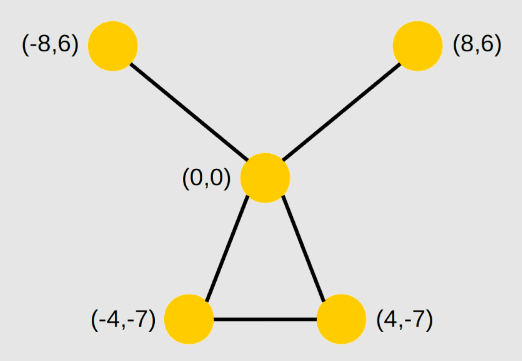

If you are not at ease with the coding, you can make full use of the graphics user interface [Pulser Studio](https://pulserstudio.pasqal.cloud/)!

In [8]:
# Loading the necessary packages, please make any necessary python installations
# Can execute as is
from pulser import Pulse, Sequence, Register
from pulser_simulation import QutipEmulator
from pulser.devices import DigitalAnalogDevice
from pulser.waveforms import InterpolatedWaveform
from itertools import combinations
from scipy.optimize import minimize
import matplotlib.pyplot as plt
import numpy as np
import igraph

#### Component A

Build a quantum register to represent the illustrated graph. When executed, your code should look like this:
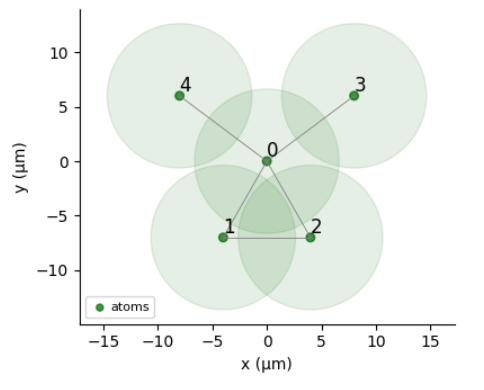

In [2]:
# Exercise A: Reproducing the graph architecture
qubits = {'0':(0, 0), '1':(-4, -7), '2':(4, -7), '3':(8, 6), '4':(-8, 6)}
reg = Register(qubits)

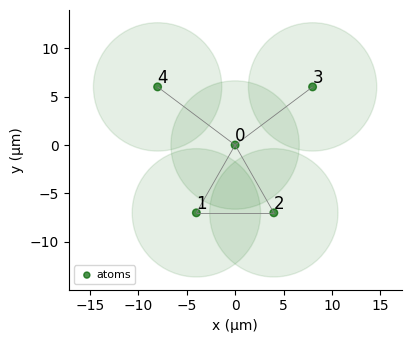

In [3]:
# Plotting the register to confirm the calibration!
# Can execute as is
reg.draw(
    blockade_radius=DigitalAnalogDevice.rydberg_blockade_radius(1.0),
    draw_graph=True,
    draw_half_radius=True,
)

#### Component B

Now let us build the sequence to implement an adiabatic evolution of the neutral atoms array. The idea behind the adiabatic algorithm is to slowly evolve the system from an easy-to-prepare ground-state to the ground-state of the cost Hamiltonian. If done slowly enough, the system of atoms stays in the instantaneous ground-state.

For the problem under study, you will continuously vary the amplitude and detuning parameters. To ensure that we are not exciting the system to states that do not form independent sets, we have to estimate the minimal distance between atoms which are not connected in the graph and estimate the furthest distance between two connected atoms.

In [15]:
# Estimating sequence parameters
link_max = 10 # Insert your computation, Maximal distance in micrometers between connected qubits in the example quantum register
no_link_min = 13.6# Insert your computation, Minimal distance in micrometers between non-connected qubits in the example quantum register

In [16]:
# Parametrising the adiabatic evolution based on computed values
# Can execute as is
Omega_min = DigitalAnalogDevice.interaction_coeff / no_link_min**6
Omega_max = DigitalAnalogDevice.interaction_coeff / link_max**6
Omega = (Omega_max - Omega_min) / 2 # we choose a random value between the min and the max

In [6]:
# Detuning parameters for the adiabatic evolution
# Can execute as is
delta_0 = -5 # just has to be negative
delta_f = -delta_0 # just has to be positive
T = 4500 # time in ns, we choose a time long enough to ensure the propagation of information

#### Pulse Shaping

From these parameters, we can build the sequence of pulses. Let us define an interpolated waveform with the aforementioned parameters for both the amplitude and the detuning parameters!

In [9]:
# Building the sequence
adiabatic_pulse = Pulse(
    InterpolatedWaveform(T, [1e-9, Omega, 1e-9]),
    InterpolatedWaveform(T, [delta_0, 0, delta_f]),
    0,
)

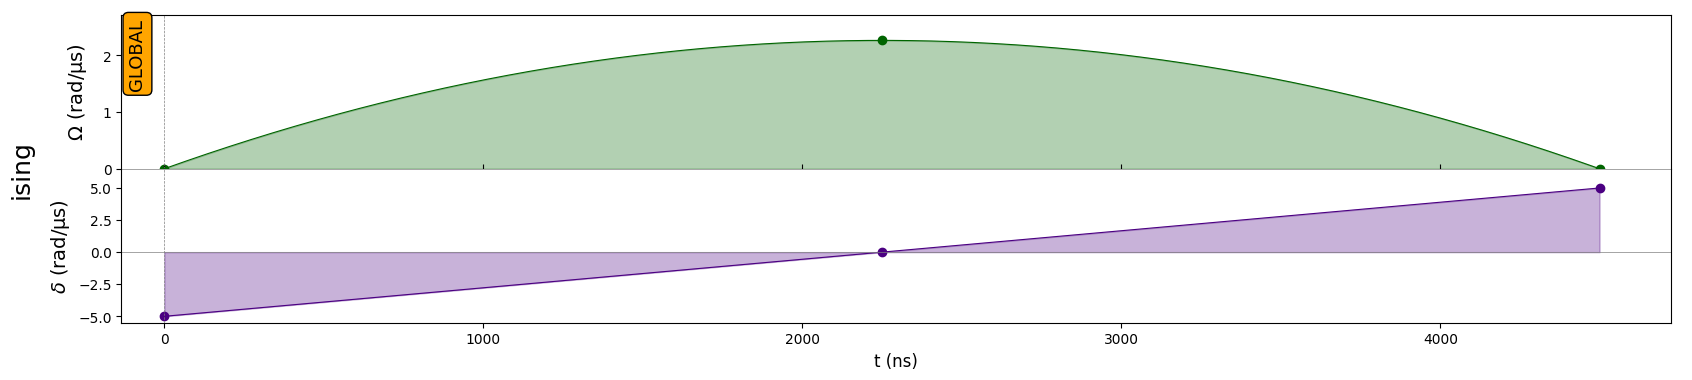

In [10]:
# Creating the channel for the laser pulse
# Can execute as is
seq = Sequence(reg, DigitalAnalogDevice)
seq.declare_channel("ising", "rydberg_global")
seq.add(adiabatic_pulse, "ising")
seq.draw()

You can now execute the sequence!

In [11]:
# Executing the sequence
# Can execute as is
simul = QutipEmulator.from_sequence(seq)
results = simul.run()
final = results.get_final_state()
count_dict = results.sample_final_state()

In [12]:
# Displaying results
# Can execute as is
def plot_distribution(C):
    C = dict(sorted(C.items(), key=lambda item: item[1], reverse=True))
    indexes = ["01011", "00111"] # MIS indexes
    color_dict = {key: "r" if key in indexes else "g" for key in C}
    plt.figure(figsize=(12, 6))
    plt.xlabel("bitstrings")
    plt.ylabel("counts")
    plt.bar(C.keys(), C.values(), width=0.5, color=color_dict.values())
    plt.xticks(rotation="vertical")
    plt.show()

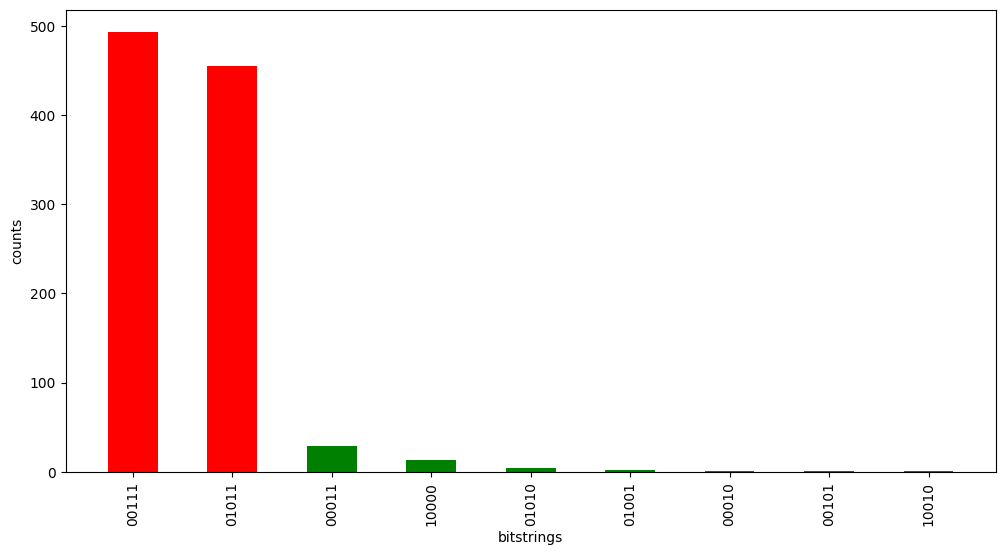

In [13]:
# Plotting the results
# Can execute as is
plot_distribution(count_dict)

#### Analysis

Let's investigate the impact of time evolution on the quality of the solution. Complete and execute the below code to observe the impact of different time evolutions and reason which regime gives the best quality solutions!

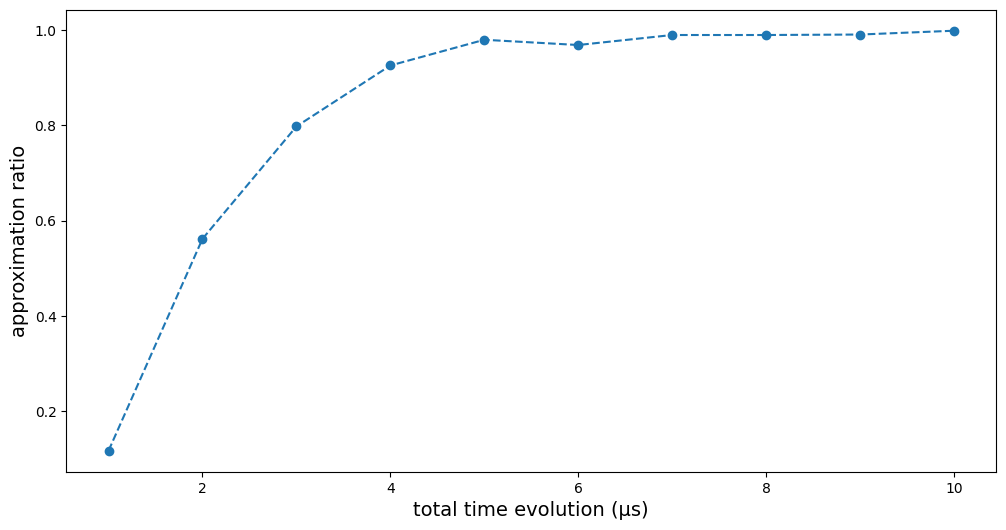

In [14]:
# Success probability vs Time evolution
# You may reuse your code from the previous exercise!
success_probability = []
for T in 1000 * np.linspace(1, 10, 10):
    seq = Sequence(reg, DigitalAnalogDevice)
    seq.declare_channel("ising", "rydberg_global")
    adiabatic_pulse = Pulse(
        InterpolatedWaveform(T, [1e-9, Omega, 1e-9]),
        InterpolatedWaveform(T, [delta_0, 0, delta_f]),
        0,
    )
    seq.add(adiabatic_pulse, "ising")
    simul = QutipEmulator.from_sequence(seq)
    results = simul.run()
    final = results.get_final_state()
    count_dict = results.sample_final_state()
    success_probability.append((count_dict["01011"]+count_dict["00111"])/1000)
    
plt.figure(figsize=(12, 6))
plt.plot(range(1, 11), np.array(success_probability), "--o")
plt.xlabel("total time evolution (μs)", fontsize=14)
plt.ylabel("approximation ratio", fontsize=14)
plt.show()